# Deep-Q-Learning

In this notebook I explore the concepts of Deep-Q-Learning by following the papers published DeepMind [V. Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf) and [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/).

As I'm intrigued by the topic of autonomous driving, the [MIT lecture videos by Lex Fridman](https://deeplearning.mit.edu/) introduced me to the topic of DQL motivated me to take a deep dive and get familiar with its concepts.

In [15]:
import gym
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense

## Preview of the game

Use **left** and **right arrows** to move the spaceship sideways and the **space bar** to use the main cannon and shoot the aliens!

If you want to move to the left/right and shoot simultaneously then use **s/d**.

As you play, the `PlayPlot` function (marked deprecated) will plot the immediate award for the actions you take. For this uncomment the callback call in the `play` function. 

In [9]:
import pygame
from gym.utils.play import play, PlayPlot

def compute_metrics(obs_t, obs_tp, action, reward, terminated, truncated, info):
    return [reward, np.linalg.norm(action)]

plotter = PlayPlot(
    compute_metrics,
    horizon_timesteps=200,
    plot_names=["Immediate Rew.", "Action Magnitude"]
)

my_env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
mapping = {(pygame.K_SPACE,): 1, (pygame.K_RIGHT,): 2, (pygame.K_LEFT,): 3, (pygame.K_d,): 4, (pygame.K_s,): 5}
play(my_env, keys_to_action=mapping) #, callback=plotter.callback)

/home/hare/.local/lib/python3.10/site-packages/gym/utils/play.py:322: DeprecationWarning: WARN: `PlayPlot` is marked as deprecated and will be removed in the near future.
  deprecation(
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
ERROR: PlayableGame wrapper works only with rgb_array and rgb_array_list render modes, but your environment render_mode = None.
/home/hare/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## Some random action taken

In [ ]:
import gym
env = gym.make("SpaceInvaders-v4", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
    action = choose_action(env, observation, 1)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we e

## Starting to define some functions

In [16]:
def choose_action (env, obs, eps):
    # get a random number
    random_number = np.random.rand()
    
    if random_number < eps:
        # we explore
        action = env.action_space.sample()
        print('we explore!')
        
    else:
        # we choose the action yielding the highest reward according to our model
        action = env.action_space.sample()
        print('we choose the best action!')
    
    return action
    

For the first attempt we'll use the architecture of the neural network described on page 6 in [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf).

### Preprocess function $\phi$

Since it will be computationally more demanding working with the raw $210 \times 160$ pixel frames, we'll apply a preprocess function $\phi$ to the frames before forwarding them to the neural network. The preprocess function will do the following
- for a single frame we take the maximum value for each pixel color value and the previous frame (removes flickering)
- the frames will be converted from RGB representation into gray-scale
- the frames will be resized to $110 \times 84$ images
- the playing area is cropped out so we have a final $84 \times 84$ frame (this is done in, but I might skip this step in this notebook [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf))
- the last 4 frames from a sequence will be modified as explained and stacked to form a $84 \times 84 \times 4$ input for the agent

So, to preprocess our input for the neuarl network, we'll need a function $\phi$ that will take the previous processed sequence $\phi_t$ and new obtained frame $x_{t+1}$ and combine them to a new processed sequence as follows

$$\phi: \phi_t, x_{t+1} \longrightarrow \phi_{t+1}$$

In [226]:
## get some observations to test the preprocess function

memory = []

env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
observation, info = env.reset(seed=42)
preprocessed = preprocess_input(observation)
memory.append(preprocessed)
for _ in range(300):
    action = choose_action(env, observation, 1)
    observation, reward, terminated, truncated, info = env.step(action)
    
    preprocessed = preprocess_input([memory[-1], observation])
    
    memory.append(preprocessed)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we explore!
we e

In [229]:
frames = memory[-2].numpy()
f1 = frames[::, ::, 0]
f2 = frames[::, ::, 1]
f3 = frames[::, ::, 2]
f4 = frames[::, ::, 3]

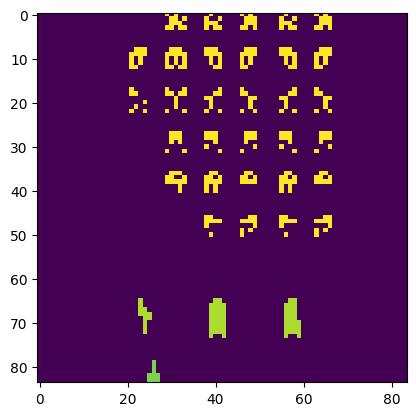

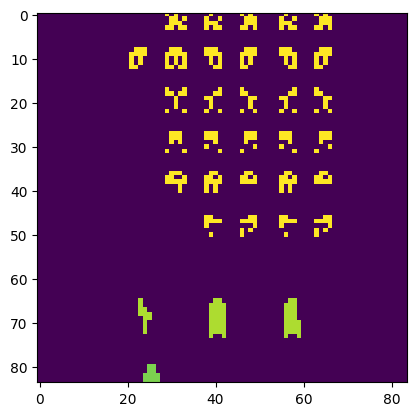

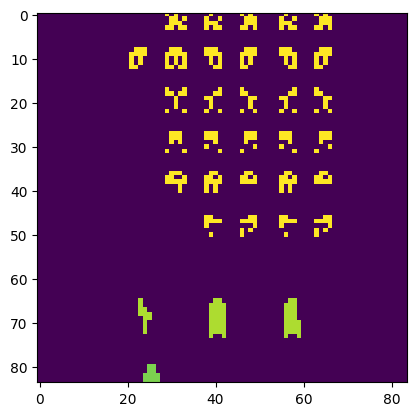

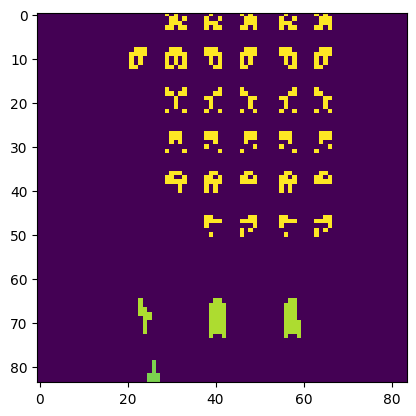

In [233]:
from matplotlib import pyplot as plt
plt.imshow(f1, interpolation='nearest')
plt.show()
plt.imshow(f2, interpolation='nearest')
plt.show()
plt.imshow(f3, interpolation='nearest')
plt.show()
plt.imshow(f4, interpolation='nearest')
plt.show()

In [225]:
def preprocess_input (state):
        # define a preprocess function for the frames recieving from the Atari games
        # we'll follow again the preprocess function proposed by Volodymir Mnih et al (2013)
        """
        Args:
            state: s_t+1 consisting of s_t, a_t, x_t+1
        Returns:
            transition: consists of phi_t, a_t, r_t, phi_t+1
        """
        
        if type(state) != type(np.zeros(0)):
            prev_seq, new_frame = state
            ## drop out the oldest frame
            if prev_seq.shape[2] > 3:
                prev_seq = prev_seq[::, ::, 1:]

            ## process new frame

            processed_fr = tf.image.rgb_to_grayscale(new_frame)
            processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
            processed_fr = tf.image.resize(processed_fr, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

            """
            ## encode frame with previous frame
            prev_frame = tf.expand_dims(prev_seq[::, ::, -1],axis=-1)
            stacked = np.stack((prev_frame, processed_fr), axis=-1)
            processed_fr = np.max(stacked, axis=-1)
            """
            
            processed_state = tf.concat([prev_seq, processed_fr], -1)


            return processed_state
        
        else:
            new_frame = state
            
            ## process new frame
        
            processed_fr = tf.image.rgb_to_grayscale(new_frame)
            processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
            processed_fr = tf.image.resize(processed_fr, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            
            return tf.expand_dims(processed_fr[::, ::, -1],axis=-1)

In [18]:
def agent (obs_shape, action_shape, learning_rate):
    # define a Sequential CNN using Keras predefined layers
    # Here we'll use the same architecture as in Volodymir Mnih et al (2013)
    model = keras.Sequential()
    model.add(Conv2D(filters=16, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu", input_shape=(84, 84, 4)))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dense(action_shape, activation="relu"))

    model.compile(loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(learning_rate=learning_rate), metrics=['accuracy'])        
    
    return model


### Replay memory

The replay memory D stores following information (called *transition*) every step

$$\left( \phi_t, \ a_t, \ r_t, \ \phi_{t+1} \right) \longrightarrow D$$

where
- $\phi_t$ is the preprocessed sequence including the frame at time step $t$
- $a_t$ is the action taken at time step $t$
- $r_t$ is the reward gained at time step $t$ after taking action $a_t$ in state $\phi_t$ $t$
- $\phi_{t+1}$ is the preprocessed sequence including the new state we reached after taking action $a_t$

In [19]:
class replay_memory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memories = []
        
    def store_transition(self, transition):
        # store transition in replay_memory
        self.memories.append(transition)
        if (len(self.memories) > self.capacity):
            self.memories.pop(0)
    
    def sample_minibatch(self):
        # sample a minibatch of transition from replay_memory
        return 0

In [20]:
my_env = gym.make("SpaceInvaders-v4",render_mode="rgb_array")
obs_shape = my_env.observation_space.shape
action_shape = my_env.action_space.n

memory_size = 10
num_of_episodes = 20
minibatch_size = 32
update_target_freq = 5    ## update target NN every 5 parameter updates (steps)
discount = 0.99
action_repeat = 4         ## repeat chosen action 4 times
update_main_freq = 4      ## SGD update main NN after 4 chosen actions
learning_rate = 0.001
grad_mom = 0.95
sq_grad_mom = 0.95
min_sq_grad = 0.01
eps = 1

warm_up = 4

In [31]:
def train_DQL():
    ## initialize replay memory D
    memories = replay_memory(memory_size)
    
    ## initialize action-value function Q with random weights
    main_model = agent(obs_shape, action_shape, learning_rate)
    
    ## initialize action-value target function with same weights 
    target_model = agent(obs_shape, action_shape, learning_rate)
    target_model.set_weights(main_model.get_weights()) 
    
    ## start outer loop of the number of episode we'll train the model for
    for episode in range(num_of_episodes):

        ## initialise sequence s1 = {x1} and preprocessed the sequence
        curr_obs, info = my_env.reset()
        curr_state = [curr_obs]
        
        while (info["lives"] > 0):
            
            ## choose an exploration/explotation action 
            curr_action = choose_action(my_env, curr_state, eps)
            
            for i in range(4):
                ## take action
                new_obs, rew, terminated, truncated, info = my_env.step(curr_action)
                hey, rew, terminated, truncated, info = my_env.step(curr_action)


                ## create new sequence with new frame
                new_state = [curr_state, new_obs]
                #curr_state = [curr_state, new_obs]

                ## preprocess state to transition
                transition = preprocess_input(new_state)

                ## store new transition
                memories.store_transition(transition)
            
            ## sample mini batch of transition
            minibatch = memories.sample_minibatch()
            
            ## compute target value
            
            ## perform gradient descent step on Loss
            
            ## update target NN weights every update_target_freq steps
            
            print(info)

## Deep-Q-learning Algorithm

<img src="./images/DQL-algorithm-2015.png" alt="dql" width="850"/>